In [53]:
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

import done


In [30]:
def mat2tfr(p_file):
    # converting mat file as numpy
    mat = loadmat(p_file)
    data = mat['dataStruct']['data'][0][0]
    # getting the filename and retrieving the patient, segement and label data
    pat, seg, label = p_file.split('/')[-1].split('.')[0].split("_")
    dstfilename = "./dataset/" + pat + "_" + seg + "_" + label + ".tfr"
    print("Converting " + p_file + " ----> " + dstfilename)
    # TensorFlow Records writer
    with tf.python_io.TFRecordWriter(dstfilename) as tfrwriter:
        # Fill protobuff
        protobuf = tf.train.Example(features=tf.train.Features(feature={
                    'data' : tf.train.Feature(float_list=tf.train.FloatList(value=data.flatten().tolist())), 
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(label)])), 
                }))
        write = tfrwriter.write(protobuf.SerializeToString())
        
        
def dataset(folder, num_files=None):
    # get files
    filenames = glob.glob(folder + "/*.mat")
    # randomize read files
    np.random.shuffle(filenames)
    # truncate reading
    if num_files is not None:
        filenames = filenames[:num_files]
    print("Converting #%d files."%len(filenames))
    
    for files in filenames:
        t = time.time()
        mat2tfr(files)
        elapsed = time.time() - t
        print("elapsed: %.3fs"%elapsed)        
        
dataset("./data/train_3", 30)

print('finished')        

Converting #30 files.
Converting ./data/train_3/3_1940_0.mat ----> ./dataset/3_1940_0.tfr
elapsed: 2.990s
Converting ./data/train_3/3_1160_0.mat ----> ./dataset/3_1160_0.tfr
elapsed: 2.669s
Converting ./data/train_3/3_696_0.mat ----> ./dataset/3_696_0.tfr
elapsed: 2.668s
Converting ./data/train_3/3_131_1.mat ----> ./dataset/3_131_1.tfr
elapsed: 2.672s
Converting ./data/train_3/3_1227_0.mat ----> ./dataset/3_1227_0.tfr
elapsed: 2.663s
Converting ./data/train_3/3_1811_0.mat ----> ./dataset/3_1811_0.tfr
elapsed: 2.808s
Converting ./data/train_3/3_419_0.mat ----> ./dataset/3_419_0.tfr
elapsed: 2.710s
Converting ./data/train_3/3_1750_0.mat ----> ./dataset/3_1750_0.tfr
elapsed: 2.738s
Converting ./data/train_3/3_353_0.mat ----> ./dataset/3_353_0.tfr
elapsed: 2.739s
Converting ./data/train_3/3_1110_0.mat ----> ./dataset/3_1110_0.tfr
elapsed: 2.725s
Converting ./data/train_3/3_734_0.mat ----> ./dataset/3_734_0.tfr
elapsed: 2.782s
Converting ./data/train_3/3_1104_0.mat ----> ./dataset/3_1104_0.

Loading #32 files.
done


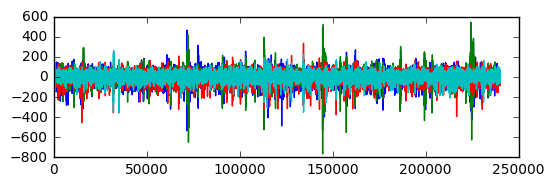

In [55]:
slim = tf.contrib.slim

def read_dataset(folder):
    with tf.Graph().as_default():
        filenames = glob.glob(folder)
        print("Loading #%d files."%len(filenames))

        reader = tf.TFRecordReader

        keys_to_features = {
            'data': tf.FixedLenFeature([240000*16], tf.float32),
            'label': tf.FixedLenFeature([], tf.int64),
        }
        items_to_handlers = {
            'data': slim.tfexample_decoder.Tensor('data'),
            'label': slim.tfexample_decoder.Tensor('label'),      
        }    
        decoder = slim.tfexample_decoder.TFExampleDecoder(
            keys_to_features, items_to_handlers)

        items_to_descriptions = {
            'data': '240000 sample points of iEEG.',
            'label': 'Label 0 indicates interictal and 1 preictal.', 
        }

        dataset = slim.dataset.Dataset(
            data_sources=filenames, 
            reader=reader, 
            decoder=decoder, 
            num_samples=1, 
            items_to_descriptions=items_to_descriptions)

        data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, shuffle=True, num_epochs=None, common_queue_capacity=16, common_queue_min=1)

        data, label = data_provider.get(['data', 'label'])

        # Batch it up.
        batch_size=1
        data, label = tf.train.batch([data, label], 
                                     batch_size=batch_size, 
                                     num_threads=1, 
                                     capacity=2*batch_size)

        with tf.Session() as sess:    
            with slim.queues.QueueRunners(sess):
                for i in xrange(2):
                    np_data, np_label = sess.run([data, label])
                    plt.subplot(211)
                    plt.plot(np_data.squeeze().reshape([240000, 16])[:,:2])
                    

read_dataset('./dataset/*.tfr')
    
print('done')
    

In [40]:
def plot_eeg(data):
    plt.figure(figsize=(10,20))
    for i in range(0,16):
        plt.subplot(8,2,i+1)
        plt.plot(data[:,i])
    
    #plt.savefig('foo.pdf', bbox_inches='tight')